# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-20 16:47:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [   <=>              ] 201.24M  8.27MB/s    in 24s     

2024-10-20 16:48:23 (8.37 MB/s) - ‘data.txt.zip’ saved [211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [5]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [6]:
set_random_seed(42)

In [7]:
from sklearn.preprocessing import StandardScaler

set_random_seed(42)

scaler_X = StandardScaler()

In [8]:
set_random_seed(42)

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

set_random_seed(42)

model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse_for_model = root_mean_squared_error(y_test, y_pred)
print(f"RMSE для Ridge", np.round(rmse_for_model, 4))

RMSE для Ridge 9.5102


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [10]:
set_random_seed(42)

best_rmse_metric = root_mean_squared_error(y_test, np.full(len(y_test), np.mean(y_train)))
print(f"RMSE для константы", np.round(best_rmse_metric, 4))

RMSE для константы 10.8525


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [11]:
set_random_seed(42)

class MyCustomDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.tensor(self.x[idx, :], dtype=torch.float32), self.y[idx]

In [12]:
set_random_seed(42)

#  Цикл обучения модели

def train(model, train_loader):
    model.train()
    for x_train, y_train in tqdm(train_loader):
        y_pred = model(x_train.to(device))
        loss = torch.mean(torch.square(y_pred - y_train.to(device)))

        loss.backward()
        with torch.no_grad():
          for weight in model.parameters():
              weight.data -= 0.001 * weight.grad
        model.zero_grad()

    return float(loss.data)

In [13]:
set_random_seed(42)

def draw_plots(train_MSE, train_RMSE, test_MSE, test_RMSE):
    clear_output(True)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].set_title('MSE', size=15)
    ax[1].set_title('RMSE', size=15)

    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Value')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Value')

    ax[0].set_xticks(np.arange(0, epoch_number, 1))
    ax[1].set_xticks(np.arange(0, epoch_number, 1))

    ax[0].plot(train_MSE, label='Train', c='blue', ls='--')
    ax[1].plot(train_RMSE, label='Train', c='blue')

    ax[0].plot(test_MSE, label='test', c='red', ls='--')
    ax[1].plot(test_RMSE, label='test', c='red')

    ax[0].legend()
    ax[1].legend()

    plt.show()

In [14]:
set_random_seed(42)

train_set = MyCustomDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4096, shuffle=True)

test_set = MyCustomDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)

model = nn.Sequential(nn.Linear(X_train.shape[1], 1)) #  Модель из одного Linear слоя
model.to(device)
epoch_number = 10

In [15]:
set_random_seed(42)

def test(model, test_loader):
    model.eval()
    with torch.no_grad():
      for x_test, y_test in tqdm(test_loader):
          y_pred = model(x_test.to(device))
          loss = torch.mean(torch.square(y_pred - y_test.to(device)))

    return float(loss.data)

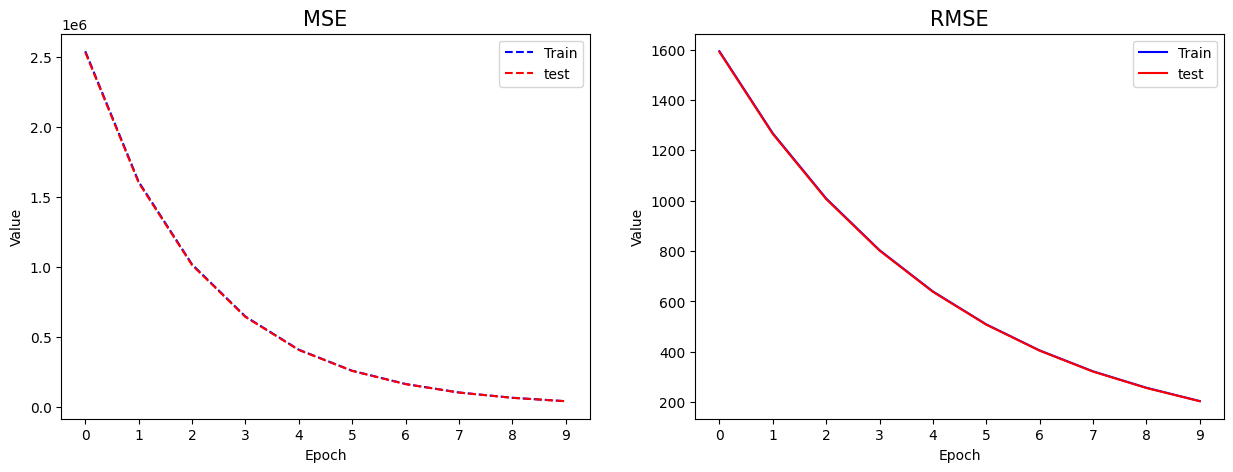

In [16]:
set_random_seed(42)

train_MSE, train_RMSE, test_MSE, test_RMSE = [], [], [], []

for epoch in range(epoch_number):

    #  TRAIN PART

    loss_train = train(model, train_loader)
    train_MSE.append(loss_train)
    train_RMSE.append(np.sqrt(loss_train))

    print(f"Train MSE: {loss_train}")
    print(f"Train RMSE: {np.sqrt(loss_train)}")
    print()

    #  TEST PART

    loss_test = test(model, test_loader)
    test_MSE.append(loss_test)
    test_RMSE.append(np.sqrt(loss_test))

    print(f"Test MSE: {loss_test}")
    print(f"Test RMSE: {np.sqrt(loss_test)}")
    print()

    # PLOTS

    draw_plots(train_MSE, train_RMSE, test_MSE, test_RMSE)


## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [17]:
set_random_seed(42)

class BestModel(nn.Module):

    def __init__(self, input_features_size: int, dropout_p: float):
        super().__init__()

        self.fully_connected1 = nn.Sequential(
            nn.Linear(input_features_size, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
        )
        self.fully_connected2 = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
        )
        self.fully_connected3 = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(256, 192),
            nn.BatchNorm1d(192),
            nn.LeakyReLU(),
        )
        self.fully_connected4 = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(192, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
        )
        self.fully_connected5 = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
        )
        self.fully_connected6 = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        result = self.fully_connected1(x)
        result = self.fully_connected2(result)
        result = self.fully_connected3(result)
        result = self.fully_connected4(result)
        result = self.fully_connected5(result)
        result = self.fully_connected6(result)

        return result

In [18]:
set_random_seed(42)

def train(model, optimizer, criterion, train_dataloader, device):
    model.train()
    for x_train, y_train in tqdm(train_dataloader):
        y_pred = model(x_train.to(device))
        loss = criterion(y_pred, y_train.to(device))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


In [19]:
set_random_seed(42)

def test(model, criterion, test_dataloader, device):
    predicts, index = torch.ones(len(test_dataloader.dataset)), 0
    model.eval()
    with torch.no_grad():
        y_pred_train = model(train_dataloader.dataset.x.to(device))
        y_pred_train_true = torch.tensor(scaler_Y.inverse_transform(y_pred_train.cpu().numpy().reshape(-1, 1)), dtype=torch.float32).squeeze()
        train_MSE = criterion(y_pred_train_true.to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
        train_RMSE = torch.sqrt(train_MSE)

        for x_test, y_test in tqdm(test_dataloader):
            y_pred = model(x_test.to(device))
            predicts[index: index + test_dataloader.batch_size] = y_pred.squeeze()
            index += test_dataloader.batch_size

    predicts_true = torch.tensor(scaler_Y.inverse_transform(predicts.cpu().numpy().reshape(-1, 1)), dtype=torch.float32).squeeze()
    test_MSE = criterion(predicts_true.to(device), test_dataloader.dataset.y.to(device))
    test_RMSE = torch.sqrt(test_MSE)

    return [predicts_true, train_MSE.item(), train_RMSE.item(), test_MSE.item(), test_RMSE.item()]


In [20]:
set_random_seed(42)

scaler_Y = StandardScaler()
y_train_scaled = scaler_Y.fit_transform(y_train.reshape(-1, 1))

In [21]:
set_random_seed(42)

train_dataset = MyCustomDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_scaled, dtype=torch.float32))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2048)

test_dataset = MyCustomDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2048)

In [22]:
set_random_seed(42)

p = 0.25

model = BestModel(torch.tensor(X_train, dtype=torch.float32).shape[1], p)
model.to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [23]:
set_random_seed(42)

predictions = test(model, criterion, test_dataloader, device)[0]

assert predictions.shape[0] == torch.tensor(y_test, dtype=torch.float32).shape[0]

  0%|          | 0/26 [00:00<?, ?it/s]

<ipython-input-11-2b2595a40eb5>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[idx, :], dtype=torch.float32), self.y[idx]


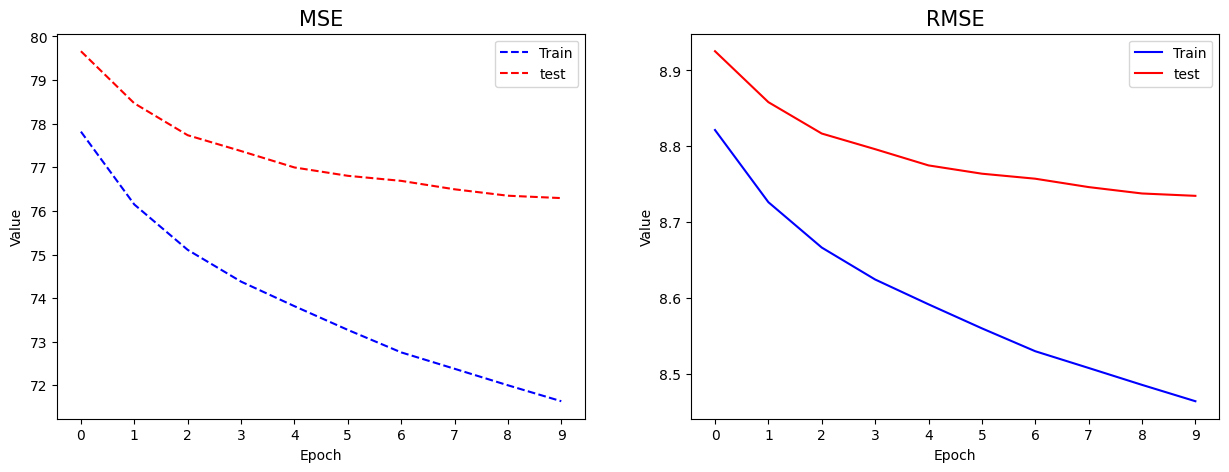


Test RMSE after all epochs: 8.734623908996582
Train MSE:  [77.81719207763672, 76.14740753173828, 75.10710144042969, 74.3789291381836, 73.81564331054688, 73.27210998535156, 72.7564468383789, 72.38048553466797, 72.0018539428711, 71.63639831542969]
Train RMSE:  [8.821405410766602, 8.726247787475586, 8.666435241699219, 8.624321937561035, 8.59160327911377, 8.55991268157959, 8.529739379882812, 8.507672309875488, 8.485390663146973, 8.463829040527344]
Test MSE:  [79.66102600097656, 78.46670532226562, 77.73534393310547, 77.3723373413086, 76.99625396728516, 76.80467987060547, 76.6886978149414, 76.49537658691406, 76.34803009033203, 76.29365539550781]
Test RMSE:  [8.925302505493164, 8.85814380645752, 8.816764831542969, 8.796154975891113, 8.774750709533691, 8.76382827758789, 8.757207870483398, 8.746163368225098, 8.737735748291016, 8.734623908996582]


In [24]:
set_random_seed(42)

epochs = 10
train_MSE, train_RMSE, test_MSE, test_RMSE = [], [], [], []

for epoch in range(epochs):
    train(model, optimizer, criterion, train_dataloader, device)

    metrics = test(model, criterion, test_dataloader, device)

    train_loss, train_metric, test_loss, test_metric = metrics[1], metrics[2], metrics[3], metrics[4]

    print(f'Train MSE: {train_loss}, Train RMSE: {train_metric}\n')
    print(f'Test MSE: {test_loss}, Test RMSE: {test_metric}\n')

    train_MSE.append(train_loss); train_RMSE.append(train_metric); test_MSE.append(test_loss); test_RMSE.append(test_metric)

    draw_plots(train_MSE, train_RMSE, test_MSE, test_RMSE)

print()
print(f'Test RMSE after all epochs: {test_RMSE[-1]}')
print(f'Train MSE: ', train_MSE)
print(f'Train RMSE: ', train_RMSE)
print(f'Test MSE: ', test_MSE)
print(f'Test RMSE: ', test_RMSE)

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

## Эксперимент 1

### Сразу скажу, что не стал вставлять в отчет самые первые модели, так как у них качество было далеко от идеала и они были слишком просты, однако стоит упомянуть, что они представляли собой простое чередование Linear и Relu.

In [25]:
class FirstModel(nn.Module):

    def __init__(self, input_features_size: int):
        super().__init__()

        self.fully_connected1 = nn.Sequential(
            nn.Linear(input_features_size, 128),
            nn.LeakyReLU(),
        )
        self.fully_connected2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(),
        )
        self.fully_connected3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        result = self.fully_connected1(x)
        result = self.fully_connected2(result)
        result = self.fully_connected3(result)

        return result

In [26]:
model = FirstModel(torch.tensor(X_train, dtype=torch.float32).shape[1])
criterion = nn.MSELoss()

### Данная модель уже показала неплохие результаты и я понял, что был на правильном пути. Она состоит из трех полносвязных слоев, в которых чередуются Linear и LeakyRelu. Было выбрано LeakyRelu, так как она показывало более лучшие результаты, чем простое Relu.

### Критерием было выбрано MSELoss и оно не изменялось.

### А вот оптимайзер менялся. Экспериментальном опытом было выведено, что Adagard подходит лучше чем GD и SGD, далее использовал его. А lr принимал равным 0.01.

In [27]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Test RMSE after all epochs: 9.015917778015137

Train MSE:  [82.93276977539062, 82.45594024658203, 82.03523254394531, 81.65860748291016, 81.31538391113281, 81.0019760131836, 80.712158203125, 80.44281768798828, 80.18930053710938, 79.95024871826172]

Train RMSE:  [9.106742858886719, 9.080525398254395, 9.057330131530762, 9.036515235900879, 9.017504692077637, 9.000109672546387, 8.983994483947754, 8.968992233276367, 8.954848289489746, 8.941490173339844]

Test MSE:  [83.70724487304688, 83.28983306884766, 82.9312744140625, 82.61590576171875, 82.33531188964844, 82.08272552490234, 81.85702514648438, 81.6513671875, 81.46227264404297, 81.28678131103516]

Test RMSE:  [9.149166107177734, 9.126326560974121, 9.106660842895508, 9.08932876586914, 9.073881149291992, 9.059951782226562, 9.047487258911133, 9.036114692687988, 9.02564525604248, 9.015917778015137]

In [28]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)

Test RMSE after all epochs: 8.826385498046875
Train MSE:  [80.25859069824219, 78.01209259033203, 76.76338958740234, 75.94664001464844, 75.35768127441406, 74.88705444335938, 74.50447082519531, 74.18090057373047, 73.90326690673828, 73.6516342163086]

Train RMSE:  [8.958715438842773, 8.83244514465332, 8.76147174835205, 8.714736938476562, 8.680880546569824, 8.653730392456055, 8.631597518920898, 8.612833023071289, 8.596700668334961, 8.582053184509277]

Test MSE:  [81.52293395996094, 80.02934265136719, 79.3143081665039, 78.89140319824219, 78.60375213623047, 78.39889526367188, 78.24052429199219, 78.10515594482422, 77.99703216552734, 77.90507507324219]
Test RMSE:  [9.02900505065918, 8.94591236114502, 8.905858039855957, 8.88208293914795, 8.865875244140625, 8.854314804077148, 8.845367431640625, 8.837712287902832, 8.831592559814453, 8.826385498046875]

### Данная модель выдала RMSE на тесте равное 8.82, что уже неплохо.

## Эксперимент 2

In [29]:
class SecondModel(nn.Module):

    def __init__(self, input_features_size: int):
        super().__init__()

        self.fully_connected1 = nn.Sequential(
            nn.Linear(input_features_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
        )
        self.fully_connected2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
        )
        self.fully_connected3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
        )
        self.fully_connected4 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        result = self.fully_connected1(x)
        result = self.fully_connected2(result)
        result = self.fully_connected3(result)
        result = self.fully_connected4(result)

        return result

### Подумав, что еще можно добавить, я решил присоединить еще один fc слой, а также нагрузить модель с BatchNorm.
### Возможно, что я сделал что-то не совсем точно, однако качество стало чуть хуже. Оно изменилось не так сильно. Однако я пробовал запускать данную модель на батче размером 4096, что возможно и повлияло на ответ. Далее я использовал batch_size=2048, но BarchNorm решил не откладывать.

Test RMSE after all epochs: 8.844674110412598

Train MSE:  [76.9473648071289, 74.76698303222656, 73.53628540039062, 72.58781433105469, 71.7646713256836, 71.03617858886719, 70.36083984375, 69.78520202636719, 69.20062255859375, 68.62281036376953]

Train RMSE:  [8.771965026855469, 8.646790504455566, 8.575329780578613, 8.519847869873047, 8.471403121948242, 8.428296089172363, 8.388136863708496, 8.353754043579102, 8.31869125366211, 8.283888816833496]

Test MSE:  [79.94635009765625, 78.54257202148438, 78.09809875488281, 77.85707092285156, 77.77803039550781, 77.79792022705078, 77.84628295898438, 77.98429107666016, 78.09197235107422, 78.22826385498047]

Test RMSE:  [8.941272735595703, 8.862424850463867, 8.837312698364258, 8.823665618896484, 8.819185256958008, 8.8203125, 8.823054313659668, 8.83087158203125, 8.836966514587402, 8.844674110412598]

## Эксперимент 3

In [30]:
class ThirdModel(nn.Module):

    def __init__(self, input_features_size: int, prob: float):
        super().__init__()

        self.fully_connected1 = nn.Sequential(
            nn.Linear(input_features_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
        )
        self.fully_connected2 = nn.Sequential(
            nn.Dropout(p=prob),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
        )
        self.fully_connected3 = nn.Sequential(
            nn.Dropout(p=prob),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
        )
        self.fully_connected4 = nn.Sequential(
            nn.Dropout(p=prob),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        result = self.fully_connected1(x)
        result = self.fully_connected2(result)
        result = self.fully_connected3(result)
        result = self.fully_connected4(result)

        return result

In [31]:
p = 0.1

model = ThirdModel(torch.tensor(X_train, dtype=torch.float32).shape[1], p)

### Последнее, из того, что мы изучили и я вспомнил был Dropout, так как было видно, что на Train качество уже ниже 8.75, в отличие от Test. Поэтому было решение добавить его в модель. И ура, это помогло снизить RMSE на тесте ниже чем 8.8. Значение p в DropOut я рассматривал разные(все эксперименты и результаты вставлять слишком громоздко), поэтому здесь показаны метрики при p = 0.1.

Test RMSE after all epochs: 8.796385498046875

Train MSE:  [80.25859069824219, 78.01209259033203, 76.76338958740234, 75.94664001464844, 75.35768127441406, 74.88705444335938, 74.50447082519531, 74.18090057373047, 73.90326690673828, 73.6516342163086]

Train RMSE:  [8.958715438842773, 8.83244514465332, 8.76147174835205, 8.714736938476562, 8.680880546569824, 8.653730392456055, 8.631597518920898, 8.612833023071289, 8.596700668334961, 8.582053184509277]

Test MSE:  [81.52293395996094, 80.02934265136719, 79.3143081665039, 78.89140319824219, 78.60375213623047, 78.39889526367188, 78.24052429199219, 78.10515594482422, 77.99703216552734, 77.90507507324219]

Test RMSE:  [9.02900505065918, 8.94591236114502, 8.905858039855957, 8.88208293914795, 8.865875244140625, 8.854314804077148, 8.845367431640625, 8.837712287902832, 8.831592559814453, 8.796385498046875]

## Лучшая модель

In [32]:
class BestModel(nn.Module):

    def __init__(self, input_features_size: int, dropout_p: float):
        super().__init__()

        self.fully_connected1 = nn.Sequential(
            nn.Linear(input_features_size, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
        )
        self.fully_connected2 = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
        )
        self.fully_connected3 = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(256, 192),
            nn.BatchNorm1d(192),
            nn.LeakyReLU(),
        )
        self.fully_connected4 = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(192, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
        )
        self.fully_connected5 = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
        )
        self.fully_connected6 = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        result = self.fully_connected1(x)
        result = self.fully_connected2(result)
        result = self.fully_connected3(result)
        result = self.fully_connected4(result)
        result = self.fully_connected5(result)
        result = self.fully_connected6(result)

        return result

In [33]:
p = 0.25

model = BestModel(torch.tensor(X_train, dtype=torch.float32).shape[1], p)
model.to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

### И наконец лучшая модель. Она представляет из себя комбинацию из 6 fully_connected слоев, в них комбинация всего, что только можно(Dropout, Linear, BatchNorm, LeakyRelu).

### Test RMSE after all epochs: 8.734623908996582

Train MSE:  [77.81719207763672, 76.14740753173828, 75.10710144042969, 74.3789291381836, 73.81564331054688, 73.27210998535156, 72.7564468383789, 72.38048553466797, 72.0018539428711, 71.63639831542969]

Train RMSE:  [8.821405410766602, 8.726247787475586, 8.666435241699219, 8.624321937561035, 8.59160327911377, 8.55991268157959, 8.529739379882812, 8.507672309875488, 8.485390663146973, 8.463829040527344]

Test MSE:  [79.66102600097656, 78.46670532226562, 77.73534393310547, 77.3723373413086, 76.99625396728516, 76.80467987060547, 76.6886978149414, 76.49537658691406, 76.34803009033203, 76.29365539550781]

Test RMSE:  [8.925302505493164, 8.85814380645752, 8.816764831542969, 8.796154975891113, 8.774750709533691, 8.76382827758789, 8.757207870483398, 8.746163368225098, 8.737735748291016, 8.734623908996582

### Скорее всего можно было сделать и более простую модель с хорошим качеством, однако в этой используются вообще все изученные нами знания. Экспериментов было намного больше, просто вставлять все их смысла не вижу. Прошу прощения, за оформление кода, из-за нехватки времени он может быть написан довольно сумбурно, также можно заметить, как бездумно добавлял set_random_seed(42) в каждую ячейку просто для того, чтобы тетрадка была воспроизводима.


## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

In [34]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer

set_random_seed(42)

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

label_encoder = LabelEncoder()
y_train_year = label_encoder.fit_transform(y_train.reshape(-1))
y_test_year = label_encoder.transform(y_test.reshape(-1))

bin_encoder = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
y_train_bin = bin_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_bin = bin_encoder.transform(y_test.reshape(-1, 1))

In [35]:
from torch.utils.data import DataLoader, TensorDataset

set_random_seed(42)

train_dataset_year = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_year.reshape(-1, 1), dtype=torch.long))
test_dataset_year = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_year.reshape(-1, 1), dtype=torch.long))

train_dataloader_year = DataLoader(train_dataset_year, batch_size=2048, shuffle=True)
test_dataloader_year = DataLoader(test_dataset_year, batch_size=1024, shuffle=False)

train_dataset_bin = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_bin.reshape(-1, 1), dtype=torch.long))
test_dataset_bin = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_bin.reshape(-1, 1), dtype=torch.long))

train_dataloader_bin = DataLoader(train_dataset_bin, batch_size=2048, shuffle=True)
test_dataloader_bin = DataLoader(test_dataset_bin, batch_size=1024, shuffle=False)

In [36]:
set_random_seed(42)

class YearClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = torch.nn.SiLU()
        self.dropout = torch.nn.Dropout(p=0.2)

        self.batch_norm0 = torch.nn.BatchNorm1d(90)
        self.linear1 = torch.nn.Linear(in_features=90, out_features=512)
        self.batch_norm1 = torch.nn.BatchNorm1d(512)
        self.linear2 = torch.nn.Linear(in_features=512, out_features=256)
        self.batch_norm2 = torch.nn.BatchNorm1d(256)
        self.linear3 = torch.nn.Linear(in_features=256, out_features=128)
        self.batch_norm3 = torch.nn.BatchNorm1d(128)
        self.output = torch.nn.Sequential(
            torch.nn.Linear(in_features=128, out_features=89),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        result = self.batch_norm0(x)
        result = self.linear1(result)
        result = self.batch_norm1(result)
        result = self.activation(result)
        result = self.dropout(result)
        result = self.linear2(result)
        result = self.batch_norm2(result)
        result = self.activation(result)
        result = self.dropout(result)
        result = self.linear3(result)
        result = self.batch_norm3(result)
        result = self.activation(result)
        result = self.dropout(result)

        return result

In [37]:
set_random_seed(42)

def train(model, optimizer, criterion, train_loader, device):
    model.train()
    for x_train, y_train in tqdm(train_loader):
        x_train, y_train = x_train.to(device), y_train.to(device).squeeze()
        y_pred = model(x_train).to(device).squeeze()
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


In [38]:
set_random_seed(42)

def test_classification(model, criterion, train_loader, test_loader):
    train_accuracy, train_precision, train_recall, test_accuracy, test_precision, test_recall, = [], [], [], [], [], []
    model.eval()
    predicts = torch.ones(len(test_loader.dataset))
    with torch.no_grad():
        y_pred = torch.argmax(model(torch.Tensor(train_loader.dataset.tensors[0]).to(device)), dim=1)
        target = train_loader.dataset.tensors[1]

        train_accurracy_value = accuracy_score(target.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
        train_precision_value = precision_score(target.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average='macro')
        train_recall_value = recall_score(target.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average='macro')

        train_accuracy.append(train_accurracy_value)
        train_precision.append(train_precision_value)
        train_recall.append(train_recall_value)

        y_pred = torch.argmax(model(torch.Tensor(test_loader.dataset.tensors[0]).to(device)), dim=1)
        target = test_loader.dataset.tensors[1]

        test_accurracy_value = accuracy_score(target.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
        test_precision_value = precision_score(target.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average='macro')
        test_recall_value = recall_score(target.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average='macro')

        test_accuracy.append(test_accurracy_value)
        test_precision.append(test_precision_value)
        test_recall.append(test_recall_value)

    return [predicts, train_accuracy, train_precision, train_recall, test_accuracy, test_precision, test_recall]


In [39]:
set_random_seed(42)

model = YearClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
epochs = 5

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

set_random_seed(42)

def train_model(model, n_epochs, optimizer, criterion, train_loader, test_loader, device=device):
    for epoch in range(n_epochs):
        train(model, optimizer, criterion, train_loader, device)

        metrics = test_classification(model, criterion, train_loader, test_loader)

        clear_output(wait=True)

        print("Train accuracy:", metrics[1])
        print("Train precision:", metrics[2])
        print("Train recall:", metrics[3])
        print()
        print("Test accuracy:", metrics[4])
        print("Test precision:", metrics[5])
        print("Test recall:", metrics[6])


In [41]:
set_random_seed(42)

assert test_classification(model, criterion, train_dataloader_year, test_dataloader_year)[0].shape[0] == y_test.shape[0]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
set_random_seed(42)

train_model(model, epochs, optimizer, criterion, train_dataloader_year, test_dataloader_year)

Train accuracy: [0.11600228588680547]
Train precision: [0.08507863288839572]
Train recall: [0.0552871800043254]

Test accuracy: [0.09488669378268448]
Test precision: [0.04639556790061732]
Test recall: [0.03973261165745806]


In [43]:
set_random_seed(42)

class YearClassifierBin(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = torch.nn.SiLU()
        self.dropout = torch.nn.Dropout(p=0.2)

        self.batch_norm0 = torch.nn.BatchNorm1d(90)
        self.linear1 = torch.nn.Linear(in_features=90, out_features=512)
        self.batch_norm1 = torch.nn.BatchNorm1d(512)
        self.linear2 = torch.nn.Linear(in_features=512, out_features=256)
        self.batch_norm2 = torch.nn.BatchNorm1d(256)
        self.linear3 = torch.nn.Linear(in_features=256, out_features=128)
        self.batch_norm3 = torch.nn.BatchNorm1d(128)
        self.output = torch.nn.Sequential(
            torch.nn.Linear(in_features=128, out_features=10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        result = self.batch_norm0(x)
        result = self.linear1(result)
        result = self.batch_norm1(result)
        result = self.activation(result)
        result = self.dropout(result)
        result = self.linear2(result)
        result = self.batch_norm2(result)
        result = self.activation(result)
        result = self.dropout(result)
        result = self.linear3(result)
        result = self.batch_norm3(result)
        result = self.activation(result)
        result = self.dropout(result)

        return result


In [44]:
set_random_seed(42)

model = YearClassifierBin().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
epochs = 5

In [45]:
set_random_seed(42)

train_model(model, epochs, optimizer, criterion, train_dataloader_bin, test_dataloader_bin)

Train accuracy: [0.5882298394487994]
Train precision: [0.4585884058311615]
Train recall: [0.24971919752016997]

Test accuracy: [0.5765833817547937]
Test precision: [0.26881471189425266]
Test recall: [0.21822500348254095]


### Можно заметить, что модели получились не особо подходящими. Значения всех метрик очень низкие. Данные плохо отражают информацию о годе выпуска. Для бинов точность получилась немного лучше, поэтому можно сделать вывод, что значения классов похожи. Можно было бы подобрать лучшую модель, чтобы выбить лучшие метрики, однако задание этого не требует.

### Для того, чтобы перейти с задачи регрессии на задачу классификации я заменил скалирование целевой переменной на кодирование целевой переменной. Была заменена MSELoss на CrossEntropy, так как она больше подходит для этой задачи. Также добавлена функция активации SoftMax, так как в задачах классификации она присутствует в отличии от регрессии. Выход нейронной сети теперь состоит из большого количества нейронов, так как в регресии это был 1 нейрон.